In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn import metrics
from sklearn import linear_model
from sklearn import datasets
from sklearn import preprocessing, utils
from sklearn.metrics import  make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
#uploading datasets
df_bank = pd.read_csv("bank.csv")

#checking up
df_bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
#encode the data
bank_encoded = pd.get_dummies(df_bank, columns=["job","marital","education","default","housing","loan",
                                                "contact","month","poutcome", "deposit"])
bank_encoded.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,deposit_no,deposit_yes
0,59,2343,5,1042,1,-1,0,1,0,0,...,1,0,0,0,0,0,0,1,0,1
1,56,45,5,1467,1,-1,0,1,0,0,...,1,0,0,0,0,0,0,1,0,1
2,41,1270,5,1389,1,-1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
3,55,2476,5,579,1,-1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
4,54,184,5,673,2,-1,0,1,0,0,...,1,0,0,0,0,0,0,1,0,1


In [4]:
#divide data into x and y
x = bank_encoded.iloc[:,:-2]
y = bank_encoded.deposit_yes

#seeing %pos in the data
pos = bank_encoded.deposit_yes.sum()
neg = len(bank_encoded) - pos

percent_pos = round(pos/len(bank_encoded)*100, 2)
percent_neg = round(neg/len(bank_encoded)*100, 2)

percent_pos

47.38

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

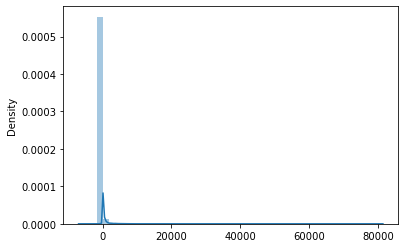

In [5]:
#checking the shape of the datasets
sns.distplot(bank_encoded, kde=True)

In [6]:
#since it is approximately normal, we will standardize using z dist
x_std = preprocessing.scale(x).astype(np.float32)
y_std = preprocessing.scale(y).astype(np.float32)


## Logistic Regression

In [7]:
result_lr = []
for trial in range(5):
    #splitting into training and testing
    x_train, x_test, y_train, y_test = train_test_split(x_std, y_std, train_size = 5000, random_state=trial,
                                                    stratify = y_std, shuffle=True)

    #encode training and testing data != continuous
    encode_ytr = preprocessing.LabelEncoder()
    ytr_encoded = encode_ytr.fit_transform(y_train)
    
    encode_yt = preprocessing.LabelEncoder()
    yt_encoded = encode_yt.fit_transform(y_test)
    
    C_list = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, np.Inf]
    alg = LogisticRegression(max_iter=5000, solver='saga')
    param_grid =  {'penalty' : ['l1', 'l2'], 'C': C_list}
    scoring_list = ['accuracy', 'precision', 'f1', 'roc_auc', 'recall']
    scoring_func_dict = {'acc':accuracy_score, 'AUC':roc_auc_score,
                        'prec':precision_score, 'recall':recall_score, 'f1':f1_score}
    scoring_dict = {k:make_scorer(v) for k,v in scoring_func_dict.items()}
    
    search_result = GridSearchCV (alg, param_grid, scoring=scoring_dict, refit=False, cv=5, n_jobs=-1)
    search_result.fit(x_train, ytr_encoded)
    
    res_one_trial = []
    for k in scoring_dict.keys():
        
        mean_test_metric = search_result.cv_results_['mean_test_'+k]
        best_idx = np.argmax(mean_test_metric)
        best_params = search_result.cv_results_['params'][best_idx]
        alg_new_5000 = LogisticRegression(max_iter=5000, solver='saga', **best_params)
        alg_new_5000.fit(x_train, ytr_encoded)
        
        res_test = alg_new_5000.predict(x_test)
        
        res_one_model = []
        for k_metric, func_metric in scoring_func_dict.items():
            metric_value = func_metric(res_test, yt_encoded)
            res_one_model.append(metric_value)

        res_one_trial.append(res_one_model)
    
    result_lr.append(res_one_trial)
result_lr = np.array(result_lr)
print(result_lr.shape)
print(np.mean(result_lr, axis=0))

(5, 5, 5)
[[0.82190847 0.82220004 0.79191781 0.82521591 0.80820885]
 [0.82190847 0.82220004 0.79191781 0.82521591 0.80820885]
 [0.81457319 0.81592483 0.77082192 0.82629516 0.79746613]
 [0.82194093 0.82222228 0.79212329 0.82513382 0.80827622]
 [0.82190847 0.82220004 0.79191781 0.82521591 0.80820885]]


In [8]:
print([k for  k in scoring_dict.keys()])
print([k for k in scoring_func_dict.keys()])

['acc', 'AUC', 'prec', 'recall', 'f1']
['acc', 'AUC', 'prec', 'recall', 'f1']
